In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
import random
from gensim.models import Word2Vec

In [97]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [98]:
# load synthesizer from saved object
with open('models/TVAE_synthesizer.pkl', 'rb') as input:
    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
synthesizer.device = 'cpu'

In [99]:
# check out sample
N = 1000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)

In [100]:
df_input = pd.read_csv('data/cc_data_input_10emb_ageCat70.csv')

In [101]:
input_columns = list(df_input.columns)[1:]

In [102]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
pd.set_option('display.max_columns', 45)
df_sample.head()

,Purchase Amount,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,SIC Description_Family Clothing Stores,SIC Description_Gasoline Service Stations,SIC Description_Grocery Stores,SIC Description_Miscellaneous Food Stores,SIC Description_Other,SIC Description_Taxicabs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,period_of_month_end,period_of_month_mid,period_of_month_start,"Age Range_(20, 25]","Age Range_(25, 30]","Age Range_(30, 35]","Age Range_(35, 40]","Age Range_(40, 45]","Age Range_(45, 50]","Age Range_(50, 55]","Age Range_(55, 60]","Age Range_(60, 65]","Age Range_(65, 70]",retailerVec_01,retailerVec_02,retailerVec_03,retailerVec_04,retailerVec_05,retailerVec_06,retailerVec_07,retailerVec_08,retailerVec_09,retailerVec_10
0,54.912223,0.000260,0.999908,-0.000025,0.999981,-0.000035,0.000013,-0.000038,0.000172,-6.565085e-06,3.982141e-07,0.999811,0.000014,0.000009,0.000005,0.000060,0.000031,0.000174,0.000009,-0.000026,0.000066,0.000043,-0.000071,-0.000108,-0.000223,0.000003,0.000035,0.000005,-0.000007,0.000065,0.000047,7.142064e-05,-0.000019,-0.000006,0.000025,0.648271,-2.139237,-0.623442,0.342540,-0.211929,-3.013277,-0.469811,-1.275442,0.705593,-1.152404
1,0.275679,0.999945,0.000201,0.000103,1.000264,-0.000060,0.000053,0.000073,0.999927,-7.734436e-06,9.904953e-05,0.000033,0.000006,0.000114,0.000038,-0.000009,0.000020,-0.000174,-0.000129,0.000037,-0.000086,0.000054,0.000083,-0.000106,0.000179,0.000016,0.000040,0.000104,-0.000003,-0.000173,0.000057,-2.055820e-06,0.000011,0.000034,-0.000014,0.649255,-1.148418,0.551537,0.407134,1.042785,0.379866,-1.493243,-0.260583,-0.874929,-0.210801
2,39.479983,1.000209,0.000012,0.999966,0.000140,0.000068,-0.000019,-0.000005,0.000121,-6.456238e-05,-6.590084e-05,0.999781,0.000051,0.000022,0.000009,0.000156,0.000071,0.000081,-0.000020,0.000017,0.000012,0.000013,-0.000045,-0.000059,0.000084,0.000070,-0.000026,-0.000134,0.000018,0.000034,-0.000059,3.116881e-07,0.000005,-0.000010,0.000018,0.802700,-0.782570,-1.877313,-0.194678,1.102184,-2.732051,-0.192432,-1.735908,-0.400063,-1.127758
3,-1.019745,0.999986,-0.000030,0.999914,-0.000021,-0.000024,0.000032,-0.000056,0.999881,4.498351e-05,1.964080e-05,-0.000246,0.000008,0.000036,-0.000093,-0.000066,-0.000052,0.000054,0.000054,0.000057,-0.000068,-0.000078,0.000159,-0.000067,-0.000150,0.000021,-0.000102,0.000030,0.000073,0.000019,0.000051,-5.728772e-05,-0.000048,0.000035,0.000057,0.194832,-0.843535,0.366154,1.026912,-0.641032,0.145044,-0.860390,-0.701646,-0.752822,0.489182
4,20.714214,0.999896,0.000031,1.000152,0.000210,0.000021,-0.000100,-0.000024,0.000085,1.156983e-07,5.031683e-06,-0.000065,0.000005,1.000074,0.000103,-0.000174,0.000145,-0.000034,0.000019,-0.000035,-0.000116,0.000099,-0.000026,-0.000125,-0.000069,-0.000059,0.000023,-0.000009,-0.000068,-0.000004,0.000028,-4.664165e-06,-0.000020,-0.000038,0.000024,0.300028,-0.710944,-1.346277,0.973328,-0.886892,-2.521499,-0.183675,-2.014724,-3.816585,1.130950


In [103]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # find column name for absolute max in each row and put into one series
    df_output = pd.Series(tmp.abs().idxmax(axis=1), name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [104]:
#df_purchase = df_sample.iloc[:,[0,1]]
df_purchase = df_sample.iloc[:,[0]]
df_age = reverse_dummy(df_sample,'Age Range')
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [167]:
#df_reverse = pd.concat([df_purchase,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)
df_reverse = pd.concat([df_purchase,df_age,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)

#pd.set_option('display.max_rows', N)
print(df_reverse.shape)
df_reverse.head()

(1000, 7)


,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,54.912223,"(50, 55]",credit_card,male,Grocery Stores,Saturday,start
1,0.275679,"(40, 45]",bank_account,male,Eating Places,Saturday,start
2,39.479983,"(30, 35]",bank_account,female,Grocery Stores,Friday,start
3,-1.019745,"(25, 30]",bank_account,female,Eating Places,Wednesday,end
4,20.714214,"(35, 40]",bank_account,female,Other,Friday,mid


In [168]:
def return_age(age_range):
    age_range = age_range.replace('(','').replace(']','').replace(' ','')
    r1 = int(age_range.split(',')[0])
    r2 = int(age_range.split(',')[1])
    return random.choice(list(range(r1+1, r2+1)))

In [169]:
df_reverse['Age'] = df_reverse.apply(lambda x: return_age(x['Age Range']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age
0,54.912223,"(50, 55]",credit_card,male,Grocery Stores,Saturday,start,51
1,0.275679,"(40, 45]",bank_account,male,Eating Places,Saturday,start,45
2,39.479983,"(30, 35]",bank_account,female,Grocery Stores,Friday,start,31
3,-1.019745,"(25, 30]",bank_account,female,Eating Places,Wednesday,end,28
4,20.714214,"(35, 40]",bank_account,female,Other,Friday,mid,37


In [108]:
#df_reverse['SIC Description'].value_counts()[:9].index.tolist()

In [144]:
##retailer_map_grouped
#for i in range(0,100):
#    word_list = retailer_map_grouped[df_SIC_vector['SIC Description'][i]]
#    print(df_SIC_vector['SIC Description'][i])
#    min_idx = model.wv.distances(df_SIC_vector['retailerVec'][i], other_words = word_list).argmin()
#    print(word_list[min_idx])
#    print('\n')

In [170]:
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]

In [171]:
# load the retailer_map
with open('models/retailer_map_processed.pkl', 'rb') as input:
    retailer_map_grouped = pickle.load(input)  

In [172]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]  

# put retailer vectors into one column
df_retailerVec['retailerVec'] = df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_reverse['SIC Description'], df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SIC Description,retailerVec
0,Grocery Stores,"[0.6482714970991128, -2.13923684397753, -0.623..."
1,Eating Places,"[0.6492551983375978, -1.1484179906427192, 0.55..."
2,Grocery Stores,"[0.8027000265289744, -0.782569861837629, -1.87..."
3,Eating Places,"[0.19483158570390846, -0.8435351949560169, 0.3..."
4,Other,"[0.3000276513481587, -0.7109440143667194, -1.3..."


In [173]:
retailer_map_grouped.keys()
#retailer_map_grouped['Gasoline Service Stations']
#df_SIC_vector['SIC Description'].value_counts()

dict_keys(['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified', 'Other'])

In [174]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [175]:
model = Word2Vec.load('models/retailer_embedding.model')
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head(20)

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer
0,54.912223,"(50, 55]",credit_card,male,Grocery Stores,Saturday,start,51,Sobeys
1,0.275679,"(40, 45]",bank_account,male,Eating Places,Saturday,start,45,Skip The Dishes
2,39.479983,"(30, 35]",bank_account,female,Grocery Stores,Friday,start,31,KAUFLAND
3,-1.019745,"(25, 30]",bank_account,female,Eating Places,Wednesday,end,28,Subway
4,20.714214,"(35, 40]",bank_account,female,Other,Friday,mid,37,Nordstrom
5,26.511858,"(20, 25]",bank_account,female,Other,Thursday,mid,23,Campbell Variety
6,0.478340,"(35, 40]",bank_account,female,Eating Places,Saturday,start,38,Wok Express
7,9.075363,"(20, 25]",credit_card,female,Eating Places,Monday,mid,21,Tim Hortons
8,15.960238,"(55, 60]",credit_card,female,Eating Places,Thursday,end,60,Rainforest Cafe
9,4.350874,"(50, 55]",credit_card,male,Drug Stores and Proprietary Stores,Thursday,end,53,Pharmaprix


In [176]:
# given period_of_month (start, mid or end) and year (1989) and month (6), return index of the possible days
def return_day_index(period_of_month, year, month):
    if period_of_month == 'start':
        return list(range(1,11))
    elif period_of_month == 'mid':
        return list(range(11,21))
    else:
        return list(range(21, pd.Period(str(year) + '-' + str(month)).days_in_month + 1))
    
# function to convert day_of_week and period_of_month back to Date, given a year and a month
# Example:
# input: day_of_week = 'Monday'; period_of_month = 'start'; Y = 2020; M = 2
# output: 2020-02-03 00:00:00

def return_date(day_of_week, period_of_month, Y, M):
    # return list of days
    D = return_day_index(period_of_month, Y, M)

    tmp = pd.DataFrame({'year': [str(Y) for i in range(len(D))],
                        'month': [str(M) for i in range(len(D))],
                        'day': D})
    
    # create table with each row of year, month and day in given period
    date_period = pd.to_datetime(tmp[['year', 'month', 'day']])

    # locate index of which date is the given day_of_week
    idx_list = [i for i, s in enumerate(date_period.dt.strftime('%A')) if day_of_week in s]

    # randomly pick up one index, since it's possible one period has multiple given weekday (say Monday)
    idx = random.choice(idx_list)

    return date_period[idx]

In [177]:
Y = 2022; M = 2
df_reverse['Transaction Date'] = df_reverse.apply(lambda x: return_date(x.day_of_week, x.period_of_month, Y, M), axis = 1)
#df_reverse.drop(['day_of_week','period_of_month'], axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date
0,54.912223,"(50, 55]",credit_card,male,Grocery Stores,Saturday,start,51,Sobeys,2022-02-05
1,0.275679,"(40, 45]",bank_account,male,Eating Places,Saturday,start,45,Skip The Dishes,2022-02-05
2,39.479983,"(30, 35]",bank_account,female,Grocery Stores,Friday,start,31,KAUFLAND,2022-02-04
3,-1.019745,"(25, 30]",bank_account,female,Eating Places,Wednesday,end,28,Subway,2022-02-23
4,20.714214,"(35, 40]",bank_account,female,Other,Friday,mid,37,Nordstrom,2022-02-11


In [178]:
print(df_reverse['day_of_week'].value_counts())
print(df_reverse['period_of_month'].value_counts())

Friday       163
Thursday     163
Saturday     151
Monday       137
Sunday       130
Wednesday    130
Tuesday      126
Name: day_of_week, dtype: int64
end      380
mid      319
start    301
Name: period_of_month, dtype: int64


In [179]:
# remove negative purchase amount
df_reverse = df_reverse[(df_reverse['Purchase Amount'] > 0)]
df_reverse.reset_index(drop=True, inplace=True)

# load processed input data to check mean purchase amount for each retailer
df_processed = pd.read_csv('data/cc_data_processed.csv')
df_processed.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Transaction Date,Age
0,credit_card,male,Red Robin,Eating Places,15.52,2019-07-01,22.0
1,bank_account,male,California Thai,Eating Places,11.29,2019-09-30,30.0
2,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,2019-06-24,34.0
3,bank_account,female,The Beer Store,Other,88.90,2018-10-01,43.0
4,bank_account,male,Intermarche,Grocery Stores,23.54,2019-12-01,62.0


In [24]:
#df_processed_G = df_processed.groupby('Normalized Retailer').agg({'Purchase Amount': {'size', 'mean'}})
#df_processed_G.sort_values([('Purchase Amount','size')], ascending=False)

In [180]:
# create columns that are mean_byRetailer_input, mean_byRetailer_syn, and apply their ratio to adjust Purchase Amount
df_reverse['mean_byRetailer_syn'] = df_reverse['Normalized Retailer'].map(df_reverse.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['mean_byRetailer_input'] = df_reverse['Normalized Retailer'].map(df_processed.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['Purchase Amount Corrected'] = df_reverse.apply(lambda x: x['Purchase Amount'] * x.mean_byRetailer_input / x.mean_byRetailer_syn, axis = 1)

df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date,mean_byRetailer_syn,mean_byRetailer_input,Purchase Amount Corrected
0,54.912223,"(50, 55]",credit_card,male,Grocery Stores,Saturday,start,51,Sobeys,2022-02-05,29.849164,57.625323,106.010828
1,0.275679,"(40, 45]",bank_account,male,Eating Places,Saturday,start,45,Skip The Dishes,2022-02-05,6.953221,35.455147,1.405714
2,39.479983,"(30, 35]",bank_account,female,Grocery Stores,Friday,start,31,KAUFLAND,2022-02-04,23.976234,19.735294,32.496725
3,20.714214,"(35, 40]",bank_account,female,Other,Friday,mid,37,Nordstrom,2022-02-11,14.939666,206.519879,286.344888
4,26.511858,"(20, 25]",bank_account,female,Other,Thursday,mid,23,Campbell Variety,2022-02-17,26.511858,12.952632,12.952632


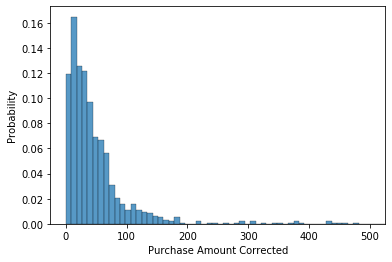

In [181]:
#sns.histplot(df_reverse['Purchase Amount'], stat="probability");
sns.histplot(df_reverse['Purchase Amount Corrected'], stat="probability");
plt.xlim(-25, 525);

#plt.savefig('figs/eda/purchase_hist_syn_ageCat70_corr.png',bbox_inches='tight')

d:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


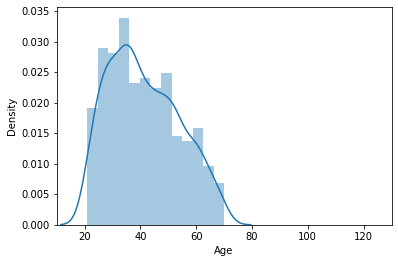

In [182]:
sns.distplot(df_reverse['Age']);
plt.xlim(10, 130);
#plt.savefig('figs/eda/age_hist_syn_ageCat70_0.5M.png',bbox_inches='tight')

In [183]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [184]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts    Per (%)
0  bank_account     543  55.979381
1   credit_card     427  44.020619


Consumer Gender
  Consumer Gender  Counts    Per (%)
0          female     543  55.979381
1            male     427  44.020619


Normalized Retailer
                   Normalized Retailer  Counts   Per (%)
341                        Tim Hortons      51  5.257732
358                            Walmart      40  4.123711
250                       Petro-Canada      34  3.505155
296                              Shell      20  2.061856
5                               Amazon      19  1.958763
..                                 ...     ...       ...
166                         King Pizza       1  0.103093
168  Krispy Kreme Doughnut Corporation       1  0.103093
170                         La Fitness       1  0.103093
174                         Le Chateau       1  0.103093
377                      humane sociey       1  0.103093

[378 rows x 3 columns]


SIC Description
     

barplot for SIC Description


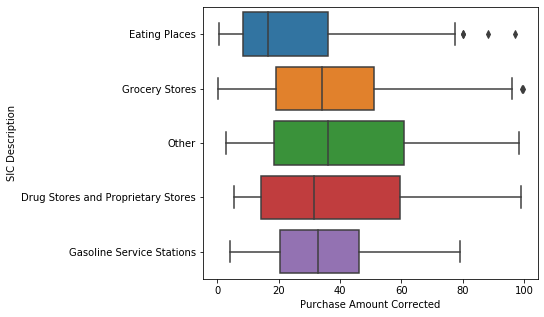

barplot for Normalized Retailer


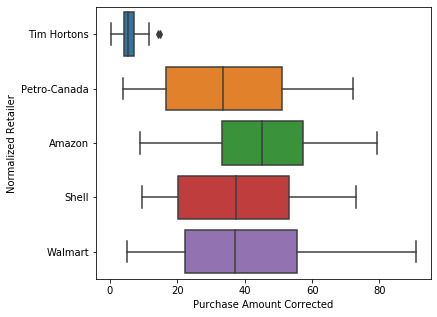

In [185]:
check_list = ['SIC Description','Normalized Retailer']
fig_dims = [6, 5] 
N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    list_tmp = df_reverse[cat].value_counts()[:N].index.tolist() # top N counts in that category
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount Corrected'] < threshold)]
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount Corrected'])
    plt.show()